In [104]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.cluster.hierarchy as sch
import scipy.stats as stats
from scipy.stats import zscore
from scipy.spatial.distance import pdist
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
import pingouin as pg
import plotly.express as px 
import plotly.io as pio
pio.renderers.default='browser'
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from sklearn.metrics import silhouette_score
from scipy.stats import kruskal
from scipy.stats import chi2_contingency


In [106]:
# Path of the database
df = pd.read_csv(r'C:\Users\act\Downloads\analise_vendedores.csv', sep=";", encoding = "cp1252", decimal = ',')

df.head(5)

,id_vendedor,nome_vendedor,categorias_atendidas,qtde_distinta_produtos,media_preco,qtde_disponivel_estoque,total_valor_estoque_usd,reputacao,status_vendedor,total_transacoes,vendas_estimativa
0,100471,TECNO-OUTLET,1,1,4.20,1,4.20,5_green,platinum,2837,11915.40
1,101217,WSBTECHNO,1,1,5.97,1,5.97,5_green,silver,1132,6758.04
2,104410,MONGETUNSA,1,1,7.68,1,7.68,4_light_green,NaN,487,3740.16
3,104859,NEWARRIVALSTORE,1,1,189.67,1,189.67,5_green,gold,1314,249226.38
4,105065,THE_MUSIC_STORE,1,1,5.04,1,5.04,5_green,platinum,8510,42890.40


In [108]:
# Exploring Data

print(df.info())
print(df.describe())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4215 entries, 0 to 4214
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id_vendedor              4215 non-null   int64  
 1   nome_vendedor            4215 non-null   object 
 2   categorias_atendidas     4215 non-null   int64  
 3   qtde_distinta_produtos   4215 non-null   int64  
 4   media_preco              4215 non-null   float64
 5   qtde_disponivel_estoque  4215 non-null   int64  
 6   total_valor_estoque_usd  4215 non-null   float64
 7   reputacao                3305 non-null   object 
 8   status_vendedor          2769 non-null   object 
 9   total_transacoes         4215 non-null   int64  
 10  vendas_estimativa        4215 non-null   float64
dtypes: float64(3), int64(5), object(3)
memory usage: 362.4+ KB
None
        id_vendedor  categorias_atendidas  qtde_distinta_produtos  \
count  4.215000e+03           4215.000000            

In [110]:
# Data Wragling

# Filling null values
df.fillna({"reputacao": "desconhecido", "status_vendedor": "desconhecido"}, inplace=True)

In [112]:
# listing categorical and number variables
categorical_features = ["reputacao", "status_vendedor"]
num_features = ["categorias_atendidas", "qtde_distinta_produtos", "media_preco", 
                "qtde_disponivel_estoque", "total_valor_estoque_usd", "total_transacoes", 
                "vendas_estimativa"]

In [114]:
# dummy variables
preprocessor = ColumnTransformer([
    ("num", StandardScaler(), num_features),  
    ("cat", OneHotEncoder(drop="first"), categorical_features)  
])


In [116]:
# Aplying transformation
df_cluster = preprocessor.fit_transform(df)

In [118]:
# Cluster creation
cluster_hier = AgglomerativeClustering(n_clusters=4, linkage='complete')
df["cluster_hier"] = cluster_hier.fit_predict(df_cluster)


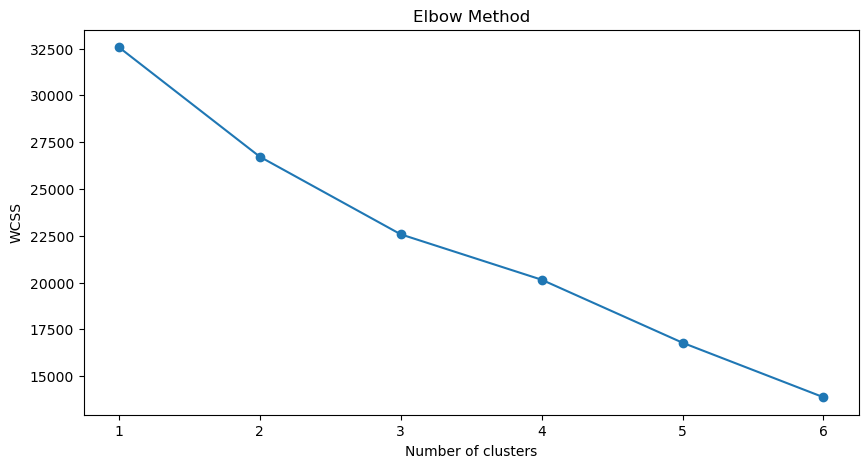

In [126]:
# Clustering K-Means

# Encountering the ideal number of cluster - in this case we are going to use 4
wcss = []
for k in range(1, 7):
    kmeans = KMeans(n_clusters=k, init='random', random_state=100)
    kmeans.fit(df_cluster)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(10,5))
plt.plot(range(1, 7), wcss, marker="o")
plt.title("Elbow Method")
plt.xlabel("Number of clusters")
plt.ylabel("WCSS")
plt.show()

In [128]:
# Aplying K-Means with 4 clusters
kmeans = KMeans(n_clusters=4, init='k-means++', random_state=100)
df["cluster_kmeans"] = kmeans.fit_predict(df_cluster)

# Silhouette Score Test for validating cluster
silhouette_avg = silhouette_score(df_cluster, df['cluster_kmeans'])
print(f'Silhouette Score for KMeans with 4 clusters: {silhouette_avg:.4f}')

# Above 0.5 → Well-defined clusters.
# Between 0.3 and 0.5 → Moderate clustering (there is some degree of overlap between clusters, but it is still usable for segmentation and analysis).
# Below 0.3 → Weak clustering (large overlap between clusters, difficult to interpret).

Silhouette Score for KMeans with 4 clusters: 0.4163


In [130]:
# Selecting the numerical variables used in clustering
num_features = ["qtde_distinta_produtos", "media_preco", "qtde_disponivel_estoque", 
                "total_valor_estoque_usd", "total_transacoes", "vendas_estimativa"]

# Creating a table to store the results
anova_results = pd.DataFrame()

# Running ANOVA for each variable
for var in num_features:
    anova = pg.anova(dv=var, between="cluster_kmeans", data=df, detailed=True)
    anova["variavel"] = var
    anova_results = pd.concat([anova_results, anova])

# Reset format after display if necessary
pd.reset_option("display.float_format")

# Show results
print("\nResultados ANOVA:")
display(anova_results)

# How to interpret?
# Higher F-values suggest larger differences between group means.
# p-value < 0.05 confirms at least one group is significantly different.



Resultados ANOVA:


,Source,SS,DF,MS,F,p-unc,np2,variavel
0,cluster_kmeans,5.295742e+04,3,1.765247e+04,687.475483,0.000000e+00,0.328756,qtde_distinta_produtos
1,Within,1.081269e+05,4211,2.567724e+01,NaN,NaN,NaN,qtde_distinta_produtos
0,cluster_kmeans,8.008506e+09,3,2.669502e+09,79.890292,2.916643e-50,0.053851,media_preco
1,Within,1.407089e+11,4211,3.341460e+07,NaN,NaN,NaN,media_preco
0,cluster_kmeans,2.670695e+10,3,8.902318e+09,343.211220,2.196906e-199,0.196471,qtde_disponivel_estoque
1,Within,1.092262e+11,4211,2.593831e+07,NaN,NaN,NaN,qtde_disponivel_estoque
0,cluster_kmeans,6.017783e+13,3,2.005928e+13,354.262835,3.806636e-205,0.201523,total_valor_estoque_usd
1,Within,2.384377e+14,4211,5.662258e+10,NaN,NaN,NaN,total_valor_estoque_usd
0,cluster_kmeans,7.824996e+12,3,2.608332e+12,1678.587337,0.000000e+00,0.544597,total_transacoes
1,Within,6.543411e+12,4211,1.553885e+09,NaN,NaN,NaN,total_transacoes


In [13]:
# Creating a table to store the results
kruskal_results = []

# Running the test for each numeric variable# Running the test for each numeric variable
for var in num_features:
    groups = [df[df["cluster_kmeans"] == c][var] for c in df["cluster_kmeans"].unique()]
    stat, p_value = kruskal(*groups)
    kruskal_results.append([var, stat, p_value])

# Creating DataFrame with the results
df_kruskal = pd.DataFrame(kruskal_results, columns=["Variável", "Estatística Kruskal", "p-valor"])

print("\nResultados Kruskal-Wallis:")
df_kruskal

# How to interpret?
# Higher H-values indicate greater separation between cluster distributions.
# p-value < 0.05 confirms significant differences.


Resultados Kruskal-Wallis:


,Variável,Estatística Kruskal,p-valor
0,qtde_distinta_produtos,522.046549,7.955297e-113
1,media_preco,329.036229,5.159013e-71
2,qtde_disponivel_estoque,1088.963012,9.026750e-236
3,total_valor_estoque_usd,1242.766217,3.856813e-269
4,total_transacoes,2584.974997,0.000000e+00
5,vendas_estimativa,2246.974067,0.000000e+00


In [14]:
# Creating contingency tables
contingencia_status = pd.crosstab(df["cluster_kmeans"], df["status_vendedor"])
contingencia_reputacao = pd.crosstab(df["cluster_kmeans"], df["reputacao"])

# Chi-Square Test for Salesperson Status
stat_status, p_status, _, _ = chi2_contingency(contingencia_status)
stat_reputacao, p_reputacao, _, _ = chi2_contingency(contingencia_reputacao)

# Creating DataFrame with the results
df_chi2 = pd.DataFrame({
    "Variável": ["Status do Vendedor", "Reputação"],
    "Estatística Qui-Quadrado": [stat_status, stat_reputacao],
    "p-valor": [p_status, p_reputacao]
})

print("\nResultados Qui-Quadrado:")
df_chi2

# How to interpret?
# Higher X² values mean a stronger relationship between clusters and the categorical variable.
# p-value < 0.05 confirms dependency (not random association).


Resultados Qui-Quadrado:


,Variável,Estatística Qui-Quadrado,p-valor
0,Status do Vendedor,3565.872114,0.0
1,Reputação,1564.128312,0.0


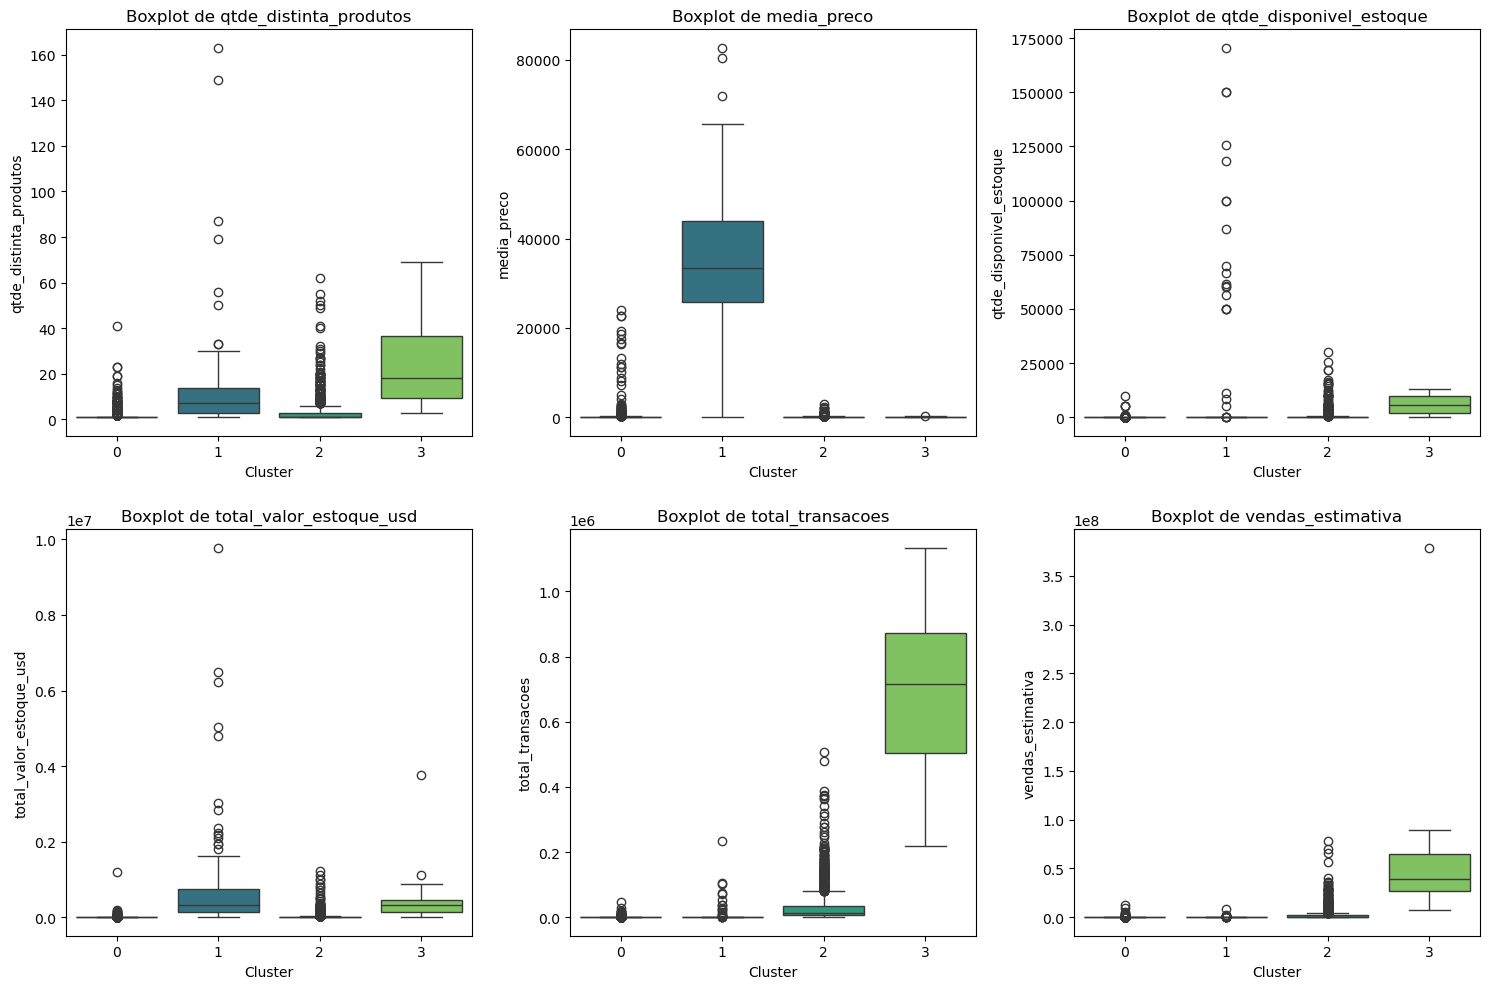

In [15]:
metrics = ["qtde_distinta_produtos", "media_preco", "qtde_disponivel_estoque", 
           "total_valor_estoque_usd", "total_transacoes", "vendas_estimativa"]

#  boxplots
plt.figure(figsize=(15, 10))
for i, metric in enumerate(metrics, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(data=df, x="cluster_kmeans", y=metric, palette="viridis")
    plt.title(f"Boxplot de {metric}")
    plt.xlabel("Cluster")
    plt.ylabel(metric)

plt.tight_layout()
plt.show()

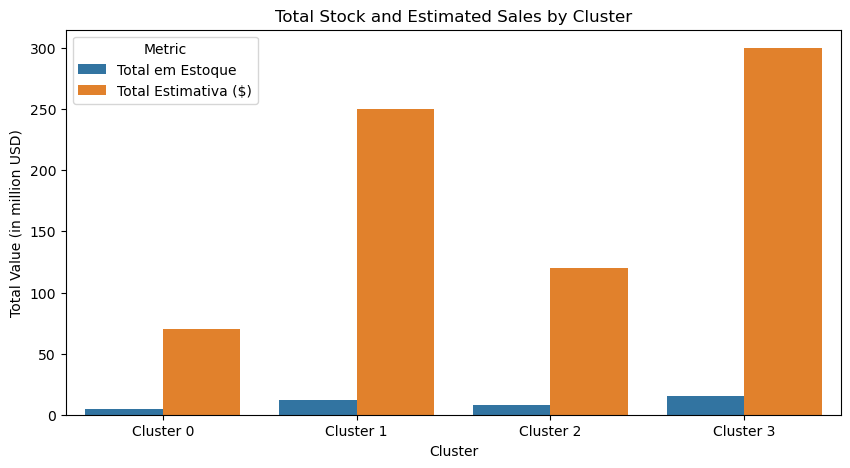

In [152]:
# Dummy dataset for clusters summary (replace with actual data)
df_cluster_summary = pd.DataFrame({
    "Cluster": ["Cluster 0", "Cluster 1", "Cluster 2", "Cluster 3"],
    "Total em Estoque": [5000000, 12000000, 8000000, 15000000],  # Example values
    "Total Estimativa ($)": [70000000, 250000000, 120000000, 300000000]  # Example values
})

# Converting values to millions for better visualization
df_cluster_summary["Total em Estoque"] = df_cluster_summary["Total em Estoque"] / 1e6
df_cluster_summary["Total Estimativa ($)"] = df_cluster_summary["Total Estimativa ($)"] / 1e6

# Melting the dataframe for easier plotting
df_cluster_summary_melted = df_cluster_summary.melt(id_vars=["Cluster"], 
                                                    value_vars=["Total em Estoque", "Total Estimativa ($)"], 
                                                    var_name="Metric", 
                                                    value_name="Value")

# Creating the barplot
plt.figure(figsize=(10, 5))
sns.barplot(data=df_cluster_summary_melted, x="Cluster", y="Value", hue="Metric")
plt.title("Total Stock and Estimated Sales by Cluster")
plt.xlabel("Cluster")
plt.ylabel("Total Value (in million USD)")
plt.legend(title="Metric")
plt.show()

In [160]:
print(df.columns)

# 3D Graph of Clusters with Salesperson Category (replace with the correct column)
fig = px.scatter_3d(df, 
                    x="media_preco", 
                    y="total_transacoes", 
                    z="qtde_disponivel_estoque",
                    color=df["cluster_kmeans"].astype(str),  # Colorir pelos clusters
                    hover_data=["nome_vendedor", "categorias_atendidas"])  # Usar a coluna correta
fig.show()

Index(['id_vendedor', 'nome_vendedor', 'categorias_atendidas',
       'qtde_distinta_produtos', 'media_preco', 'qtde_disponivel_estoque',
       'total_valor_estoque_usd', 'reputacao', 'status_vendedor',
       'total_transacoes', 'vendas_estimativa', 'cluster_hier',
       'cluster_kmeans'],
      dtype='object')


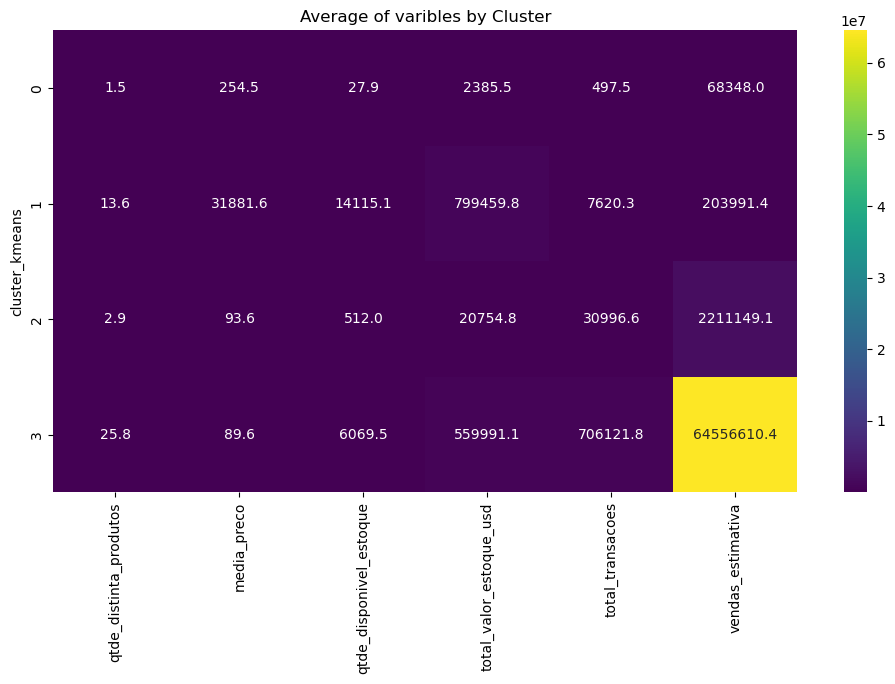

In [19]:
# Group the data by cluster and calculate the mean of the numeric variables
df_clusters_resumo = df.groupby("cluster_kmeans")[[
    "qtde_distinta_produtos", "media_preco", "qtde_disponivel_estoque",
    "total_valor_estoque_usd", "total_transacoes", "vendas_estimativa"
]].mean().reset_index()


# View variable means by cluster
plt.figure(figsize=(12, 6))
sns.heatmap(df_clusters_resumo.set_index("cluster_kmeans"), annot=True, fmt=".1f", cmap="viridis")
plt.title("Average of varibles by Cluster")
plt.show()


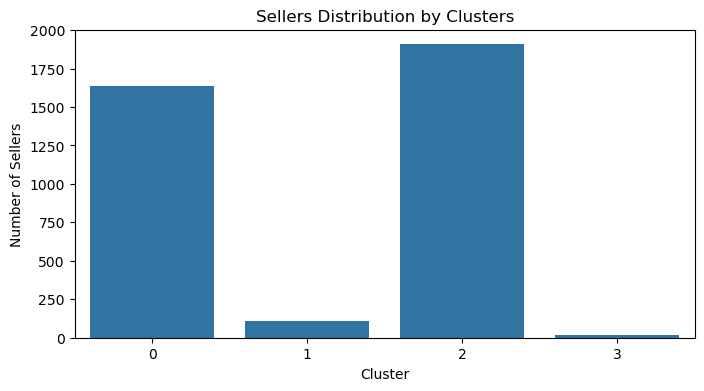

In [20]:

#Cluster Distribution

plt.figure(figsize=(8, 4))
sns.countplot(x=df["cluster_kmeans"])
plt.title("Sellers Distribution by Clusters")
plt.xlabel("Cluster")
plt.ylabel("Number of Sellers")
plt.show()


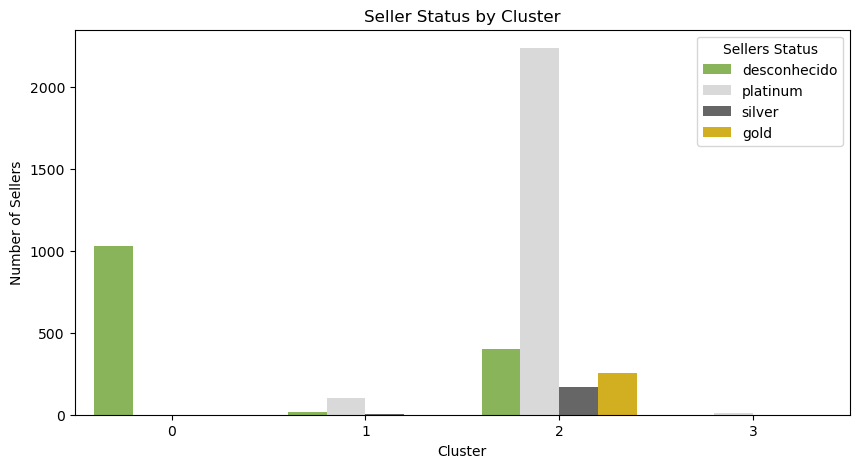

In [132]:
# Analyzing Clusters by Seller Status
# We want to understand if there is a concentration of Platinum, Gold or Silver sellers in any cluster.

cores_status = {
    "silver": "#666666",       
    "desconhecido": "#8BC34A", 
    "gold": "#EFBF04",      
    "platinum": "#D9D9D9"  
}

plt.figure(figsize=(10, 5))
sns.countplot(
    x=df["cluster_kmeans"], 
    hue=df["status_vendedor"],
    palette=cores_status
)
plt.title("Seller Status by Cluster")
plt.xlabel("Cluster")
plt.ylabel("Number of Sellers")
plt.legend(title="Sellers Status")
plt.show()


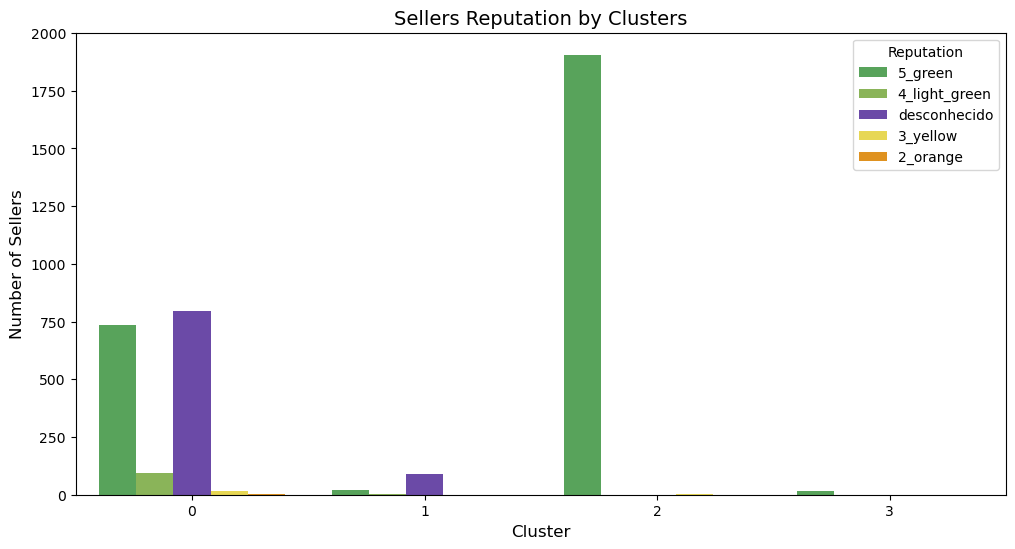

In [22]:
# Define a color dictionary for each reputation
cores_reputacao = {
    "5_green": "#4CAF50",       # Verde forte
    "4_light_green": "#8BC34A", # Verde claro
    "3_yellow": "#FFEB3B",      # Amarelo
    "2_orange": "#FF9800",      # Laranja
    "1_red": "#F44336",         # Vermelho
    "desconhecido": "#673AB7"   # Roxo (para valores desconhecidos)
}

# Create the chart with the custom palette
plt.figure(figsize=(12, 6))
sns.countplot(
    x=df["cluster_kmeans"], 
    hue=df["reputacao"], 
    palette=cores_reputacao
)

# Adjust titles and labels
plt.title("Sellers Reputation by Clusters", fontsize=14)
plt.xlabel("Cluster", fontsize=12)
plt.ylabel("Number of Sellers", fontsize=12)
plt.legend(title="Reputation", fontsize=10)
plt.show()


In [23]:
# Creating a summary table of clusters
df_cluster_summary = df.groupby("cluster_kmeans").agg(
    total_vendedores=("id_vendedor", "count"),  # Contando a quantidade de vendedores
    total_estoque=("qtde_disponivel_estoque", "sum"),
    total_estimativa=("vendas_estimativa", "sum"),
    total_transacoes=("total_transacoes", "sum")
).reset_index()

# Calculating shares (%)
df_cluster_summary["share_estoque"] = df_cluster_summary["total_estoque"] / df_cluster_summary["total_estoque"].sum() * 100
df_cluster_summary["share_estimativa"] = df_cluster_summary["total_estimativa"] / df_cluster_summary["total_estimativa"].sum() * 100
df_cluster_summary["share_transacoes"] = df_cluster_summary["total_transacoes"] / df_cluster_summary["total_transacoes"].sum() * 100
df_cluster_summary["share_vendedores"] = df_cluster_summary["total_vendedores"] / df_cluster_summary["total_vendedores"].sum() * 100

# Calculating the Average Ticket per Salesperson
df_cluster_summary["Estoque Medio p Vendedor"] = df_cluster_summary["total_estoque"] / df_cluster_summary["total_vendedores"]
df_cluster_summary["Estimativa Vendas p Vendedor"] = df_cluster_summary["total_estimativa"] / df_cluster_summary["total_vendedores"]

# Renaming columns
df_cluster_summary.rename(columns={
    "cluster_kmeans": "Cluster",
    "total_vendedores": "Quantidade de Vendedores",
    "total_estoque": "Total em Estoque",
    "share_estoque": "Share Estoque (%)",
    "total_estimativa": "Total Estimativa ($)",
    "share_estimativa": "Share Estimativa (%)",
    "total_transacoes": "Total Transações",
    "share_transacoes": "Share Transações (%)",
    "share_vendedores": "Share Vendedores (%)"
}, inplace=True)

# Formatting numbers for better visualization
df_cluster_summary["Total em Estoque"] = df_cluster_summary["Total em Estoque"].apply(lambda x: f"{x:,.0f}")
df_cluster_summary["Total Estimativa ($)"] = df_cluster_summary["Total Estimativa ($)"].apply(lambda x: f"{x/1e6:.2f}M")
df_cluster_summary["Total Transações"] = df_cluster_summary["Total Transações"].apply(lambda x: f"{x:,.0f}")
df_cluster_summary["Quantidade de Vendedores"] = df_cluster_summary["Quantidade de Vendedores"].apply(lambda x: f"{x:,.0f}")
df_cluster_summary["Estoque Medio p Vendedor"] = df_cluster_summary["Estoque Medio p Vendedor"].apply(lambda x: f"{x:,.0f}")
df_cluster_summary["Estimativa Vendas p Vendedor"] = df_cluster_summary["Estimativa Vendas p Vendedor"].apply(lambda x: f"{x/1e6:.2f}M")

# Formatting shares to display with percentage
df_cluster_summary["Share Estoque (%)"] = df_cluster_summary["Share Estoque (%)"].apply(lambda x: f"{x:.1f}%")
df_cluster_summary["Share Estimativa (%)"] = df_cluster_summary["Share Estimativa (%)"].apply(lambda x: f"{x:.1f}%")
df_cluster_summary["Share Transações (%)"] = df_cluster_summary["Share Transações (%)"].apply(lambda x: f"{x:.1f}%")
df_cluster_summary["Share Vendedores (%)"] = df_cluster_summary["Share Vendedores (%)"].apply(lambda x: f"{x:.1f}%")


In [24]:
df_cluster_summary

,Cluster,Quantidade de Vendedores,Total em Estoque,Total Estimativa ($),Total Transações,Share Estoque (%),Share Estimativa (%),Share Transações (%),Share Vendedores (%),Estoque Medio p Vendedor,Estimativa Vendas p Vendedor
0,0,"1,635","45,607",111.75M,"813,410",1.7%,2.1%,1.1%,44.6%,28,0.07M
1,1,110,"1,552,661",22.44M,"838,229",58.1%,0.4%,1.2%,3.0%,"14,115",0.20M
2,2,"1,907","976,381",4216.66M,"59,110,555",36.5%,78.3%,82.0%,52.0%,512,2.21M
3,3,16,"97,112",1032.91M,"11,297,948",3.6%,19.2%,15.7%,0.4%,"6,070",64.56M


In [148]:
# Ensure clusters are sorted in the correct order
top_sellers_per_cluster = {}

for cluster in sorted(df["cluster_kmeans"].unique()):
    top_sellers = df[df["cluster_kmeans"] == cluster].nlargest(10, "total_transacoes")[["nome_vendedor", "total_transacoes"]]
    top_sellers_per_cluster[cluster] = top_sellers["nome_vendedor"].tolist()

# Convert the dictionary to a DataFrame for display
df_top_sellers = pd.DataFrame.from_dict(top_sellers_per_cluster, orient='index').transpose()
df_top_sellers.columns = [f"Cluster {col}" for col in df_top_sellers.columns]

In [150]:
display(df_top_sellers)

,Cluster 0,Cluster 1,Cluster 2,Cluster 3
0,GRUPOAGG2016,MERCADOLIBRE SUPERMERCADO_AR,PERFUFLEX,FARMACIA SELMA
1,DREAN.ML,ECOMODICO,DD2REGALOS,BIDCOM STORES
2,ACCESORIOS ALSINA,FARMACITY_OFICIAL,FASMOTOS00,MERCADOLIBRE ELECTRONICA_AR
3,RELOJIN,MERCADOLIBRE MODA_AR,SBSLIBRERIAS,LIBERCAM
4,ALPHA-SEGURIDAD,CAPSULANDIA,DIGITAL SPORT,BIDCOM
5,JCDISCOS,TAP GROCERY,ODINROXS,ADIDASARGENTINASAADIDASARG
6,REPUESTOS SALAVERRI,PIDEWEB,BEAUTIFULL REGALOS,PHOTOSTORE
7,DATCOM,MORASHOP.AR,LAHUELLA IMPORT,TECNOFAST_
8,NAYEM.NAYEM2009,OPEN25HS ML,LIBRENTA,None
9,ARTICULOSDEAYER,MEJORPRECIO.COM.AR,MONTOYA IMPORTADORA,None


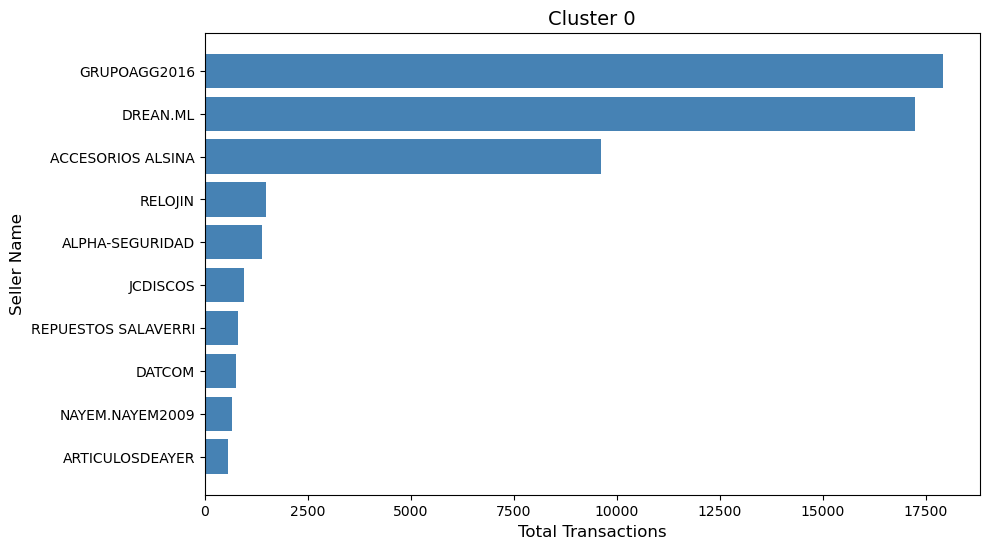

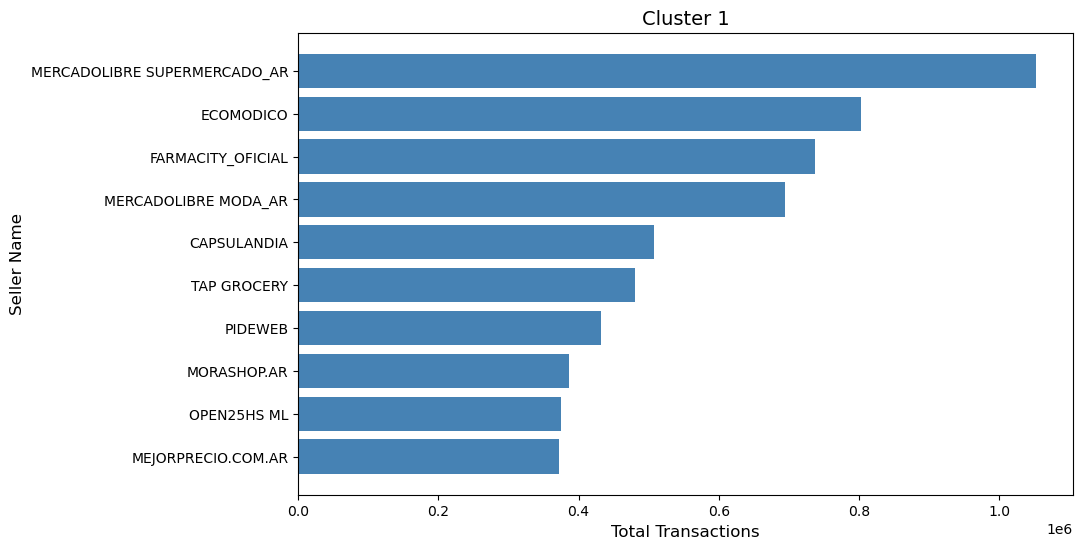

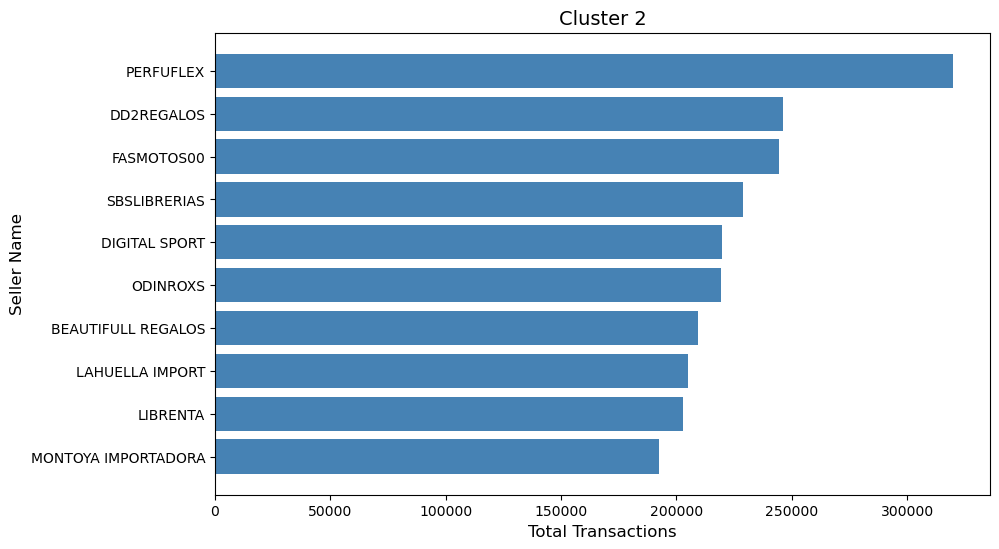

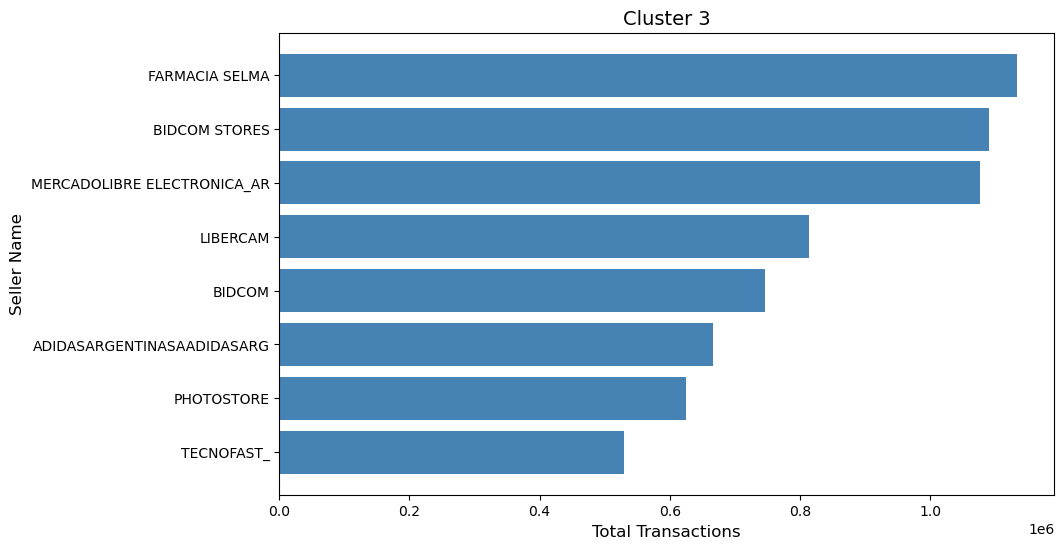

In [164]:
# Creating individual horizontal bar plots for each cluster with adjusted y-axis size
for cluster in sorted(df["cluster_kmeans"].unique()):
    top_sellers = df[df["cluster_kmeans"] == cluster].nlargest(10, "total_transacoes")[["nome_vendedor", "total_transacoes"]]
    
    plt.figure(figsize=(10, 6))  # Adjusting figure size
    plt.barh(top_sellers["nome_vendedor"], top_sellers["total_transacoes"], color="steelblue")
    plt.xlabel("Total Transactions", fontsize=12)
    plt.ylabel("Seller Name", fontsize=12)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.title(f"Cluster {cluster}", fontsize=14)
    plt.gca().invert_yaxis()  # Invert y-axis to have highest values at the top
    plt.show()

In [154]:
df_resultado_clusters = df[["id_vendedor", "nome_vendedor", "cluster_kmeans", "qtde_distinta_produtos", "media_preco", "qtde_disponivel_estoque",
    "total_valor_estoque_usd", "total_transacoes", "vendas_estimativa"]]

In [156]:
df_resultado_clusters.to_excel(r'C:\Users\act\Downloads\df_resultado_clusters.xlsx', index = False)